**1. Data download and Initialization**

These first few cells install pyro and download the frey faces Dataset.

What we need from here is the ```ff``` numpy array that holds all the frey faces with ```shape``` 1965x28x20.

In [ ]:
!pip3 install pyro-ppl 

In [ ]:
import torch
import pyro
import pyro.distributions as dist
import torch.distributions.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS

torch.manual_seed(101)
pyro.set_rng_seed(101)
np.random.seed(101)

In [ ]:
# get frey faces
# download and visualization snippet copied from https://dohmatob.github.io/research/2016/10/22/VAE.html

import os
from urllib.request import urlopen, URLError, HTTPError
from scipy.io import loadmat


def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")

    #handle errors
    except (HTTPError, e):
        print("HTTP Error:", e.code, url)
    except (URLError, e):
        print("URL Error:", e.reason, url)
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists." % data_filename)
    
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Data file frey_rawface.mat exists.


In [ ]:
# split data into training and test sets
from torch.utils.data import DataLoader

train_set, test_set = torch.utils.data.random_split(ff, [1572, 393])
train_loader = DataLoader(train_set, batch_size=1572)
test_loader = DataLoader(test_set, batch_size=393)

**2. Model Definition**
The Gamma-Poisson Model is defined here and valid for all approximation/sampling techniques.

In [ ]:
def model(data, U = 28, I = 20, K = 10):
    # Draw parameters
    theta = pyro.sample('theta', dist.Gamma(1., 1.).expand([U, K]).to_event(2))
    beta = pyro.sample('beta', dist.Gamma(1., 1.).expand([K, I]).to_event(2))

    # Generate observations
    with pyro.plate("data", len(data)):
        obs = pyro.sample("obs", dist.Poisson(torch.mm(theta, beta)).to_event(2), obs = data)

    return obs

**3.1 ADVI**
The ADVI implementation consists of a custom positive-ordered transformation, the custom guide and the actual learning.

In [ ]:
# TRANSFORM
# This is numerically unstable
class ordered_transform_broken(transforms.Transform):
      bijective = True
      domain = dist.constraints.real_vector
      codomain = dist.constraints.real_vector
      sign = +1

      def _call(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=1)):
              if i == 0:
                  y[:,i] = x[:,i]
              else:
                  y[:,i] = torch.exp(x[:,i]) + x[:,i-1]
          return y

      def _inverse(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=1)):
              if i == 0:
                  y[:,i] = x[:,i]
              else:
                  y[:,i] = torch.log(x[:,i] - x[:,i-1])
          return y

      def log_abs_det_jacobian(self, x, y):
          z = torch.ones(y.size(dim=0))
          for i in range(y.size(dim=1)):
              if i > 0:
                  z = z * torch.exp(y[:,i])
          return z

# positive_ordered_transform = transforms.ComposeTransform([transforms.ExpTransform(), ordered_transform()])

# This is what I am actually using
class positive_ordered_transform(transforms.Transform):
      bijective = True
      domain = dist.constraints.real_vector
      codomain = dist.constraints.real_vector
      sign = +1

      def _call(self, x):
          y = torch.zeros_like(x)
          for i in range(x.size(dim=1)):
              if i == 0:
                  y[:,i] = torch.exp(x[:,i])
              else:
                  y[:,i] = torch.exp(x[:,i]) + y[:,i-1]
          assert(torch.isnan(y).any() == False)
          assert(torch.min(y) >= 0)
          return y

      def _inverse(self, y):
          x = torch.zeros_like(y)
          for i in range(y.size(dim=1)):
              if i == 0:
                  x[:,i] = torch.log(y[:,i])
              else:
                  x[:,i] = torch.log(y[:,i] - y[:,i-1])
          assert(torch.isnan(x).any() == False)
          return x

      # TODO: double-check mathematical correctness of this!
      def log_abs_det_jacobian(self, x, y):
          result = x.sum(axis=1)
          # print(result.size())
          return result

In [ ]:
# GUIDE
def guide(y, U = 28, I = 20, K = 10):
    # theta params
    theta_mu = torch.randn([U,K])
    theta_sigma = torch.log(torch.abs(torch.randn([U,K])))
    theta_mu_param = pyro.param("theta_mu", theta_mu)
    theta_sigma_param = pyro.param("theta_sigma", theta_sigma)
    pyro.sample("theta", dist.TransformedDistribution(dist.Normal(theta_mu_param, torch.exp(theta_sigma_param)), positive_ordered_transform()).to_event(1))

    # beta params
    beta_mu = torch.randn([K,I])
    beta_sigma = torch.log(torch.abs(torch.randn([K,I])))
    beta_mu_param = pyro.param("beta_mu", beta_mu)
    beta_sigma_param = pyro.param("beta_sigma", beta_sigma)
    pyro.sample("beta", dist.TransformedDistribution(dist.Normal(beta_mu_param, torch.exp(beta_sigma_param)), transforms.ExpTransform()).to_event(2))

In [ ]:
def run_advi(model, guide, num_iterations=2000, verbose=False):

    adam = pyro.optim.Adam({"lr": 0.1})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    pyro.clear_param_store()

    output_advi = pd.DataFrame(columns = ["t", "test_log_prob", "model"])

    train_time = 0
    for j in range(num_iterations):
        loss = 0

        t0 = time.time()
        for data in train_loader:
            loss += svi.step(data)
        t1 = time.time()
        train_time += (t1-t0)

        if verbose and j%100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(train_loader.dataset)))

        learned_theta_mu = pyro.get_param_store().get_param('theta_mu')
        learned_beta_mu = pyro.get_param_store().get_param('beta_mu')
        poiss_dist = dist.Poisson(torch.mm(positive_ordered_transform()(learned_theta_mu), torch.exp(learned_beta_mu)))

        test_log_prob = 0
        for data in test_loader:
          test_log_prob += poiss_dist.log_prob(data).sum()

        output_iter = {"t": train_time,
                       "test_log_prob": test_log_prob.detach().numpy() / float(len(test_loader.dataset) * 20 * 28),
                       "model": "advi_" + str(num_iterations)}

        output_advi = output_advi.append(output_iter, ignore_index = True)

    return output_advi

**3.2 NUTS**

Simpler than ADVI, we just use the NUTS sampler and inspect the learned factors.
TODO: log_probs at every step

In [ ]:
def run_nuts(model, num_samples=300, num_warmup_steps=None):
    pyro.clear_param_store()

    if num_warmup_steps is None:
        num_warmup_steps = num_samples

    test_log_prob_list = []
    train_time_list = []

    def hook_function(kernel, sample, stage, i):
        #use the most recently sampled param to estimate performance
        if i < 100 or (i % 25 == 0): #evaluate all first 100 samples and then every 25
            learned_beta = torch.exp(sample['beta'])
            learned_theta = torch.exp(sample['theta'])
            
            poiss_dist = dist.Poisson(torch.mm(learned_theta, learned_beta))
            test_log_prob = 0
            for data in test_loader:
                test_log_prob += poiss_dist.log_prob(data).sum()

            train_time_list.append(time.time())    
            test_log_prob_list.append(test_log_prob / float(len(test_loader.dataset) * 20 * 28))


    nuts_kernel = NUTS(model, max_tree_depth = 4)

    nuts = MCMC(
                nuts_kernel,
                num_samples=num_samples,
                warmup_steps=num_warmup_steps,
                disable_progbar=False,
                num_chains = 1,
                hook_fn = hook_function) 

    nuts.run(torch.tensor(train_set))

    output_nuts = pd.DataFrame({'t':np.array(train_time_list)-train_time_list[0], 
                          "test_log_prob":np.array(test_log_prob_list),
                          "model":"nuts"})

    return output_nuts

Running ADVI with M = 1 ...
Done
Running MCMC with NUTS kernel ...


Sample: 100%|██████████| 400/400 [04:14,  1.57it/s, step size=2.19e-06, acc. prob=0.809]

Done
Generating plots ...


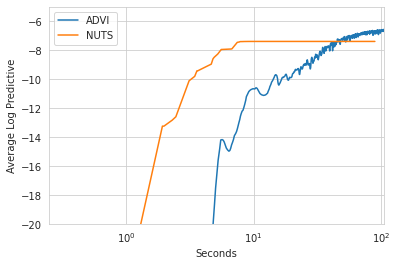

In [ ]:
# Train the ADVI models
print('Running ADVI with M = 1 ...')
output_advi = run_advi(model, guide)
print('Done')

# Train the MCMC model 
print('Running MCMC with NUTS kernel ...')
output_nuts = run_nuts(model, num_samples=200)
print('Done')

# Generate plot
print('Generating plots ...')
output = output_advi.append(output_nuts, ignore_index = True)
output = output.loc[output['t'] < 105]
output['test_log_prob'] = output['test_log_prob'].astype('float')

sns.set_style("whitegrid")
results = sns.lineplot(data = output, x = 't', y = 'test_log_prob', hue = 'model')
results.set(xscale='log', 
            xlim = (0.25, 105), 
            ylim = (-20, -5),
            xlabel = 'Seconds',
            ylabel = 'Average Log Predictive')
plt.legend(labels=["ADVI","NUTS"])